The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l


# Implementation of Softmax Regression from Scratch
:label:`sec_softmax_scratch`

Just as we implemented linear regression from scratch,
we believe that multiclass logistic (softmax) regression
is similarly fundamental and you ought to know
the gory details of how to implement it yourself.
As with linear regression, after doing things by hand
we will breeze through an implementation in Gluon for comparison.
To begin, let us import the familiar packages.

In [1]:
from d2l import torch as d2l
import torch
from IPython import display

We will work with the Fashion-MNIST dataset, just introduced in :numref:`sec_fashion_mnist`,
setting up an iterator with batch size $256$.

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initializing Model Parameters

As in our linear regression example,
each example here will be represented by a fixed-length vector.
Each example in the raw data is a $28 \times 28$ image.
In this section, we will flatten each image,
treating them as $784$-long 1D vectors.
In the future, we will talk about more sophisticated strategies
for exploiting the spatial structure in images,
but for now we treat each pixel location as just another feature.

Recall that in softmax regression,
we have as many outputs as there are categories.
Because our dataset has $10$ categories,
our network will have an output dimension of $10$.
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ vector.
As with linear regression, we will initialize our weights $W$
with Gaussian noise and our biases to take the initial value $0$.

In [3]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## The Softmax

Before implementing the softmax regression model,
let us briefly review how operators such as `sum` work
along specific dimensions in an `ndarray`.
Given a matrix `X` we can sum over all elements (default) or only
over elements in the same axis, *i.e.*, the column (`axis=0`) or the same row (`axis=1`).
Note that if `X` is an array with shape `(2, 3)`
and we sum over the columns (`X.sum(axis=0)`),
the result will be a (1D) vector with shape `(3,)`.
If we want to keep the number of axes in the original array
(resulting in a 2D array with shape `(1, 3)`),
rather than collapsing out the dimension that we summed over
we can specify `keepdims=True` when invoking `sum`.

In [4]:
X = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
torch.sum(X, dim=0, keepdim=True), torch.sum(X, dim=1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

We are now ready to implement the softmax function.
Recall that softmax consists of two steps:
First, we exponentiate each term (using `exp`).
Then, we sum over each row (we have one row per example in the batch)
to get the normalization constants for each example.
Finally, we divide each row by its normalization constant,
ensuring that the result sums to $1$.
Before looking at the code, let us recall
how this looks expressed as an equation:

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}.
$$

The denominator, or normalization constant,
is also sometimes called the partition function
(and its logarithm is called the log-partition function).
The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
where a related equation models the distribution
over an ensemble of particles.

In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = torch.sum(X_exp, dim=1, keepdim=True)
    return X_exp / partition  # The broadcast mechanism is applied here

As you can see, for any random input,
we turn each element into a non-negative number.
Moreover, each row sums up to 1,
as is required for a probability.
Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because we failed to take precautions against numerical overflow or underflow
due to large (or very small) elements of the matrix,
as we did in :numref:`sec_naive_bayes`.

In [6]:
X = torch.normal(0, 1, size=(2, 5))
X_prob = softmax(X)
X_prob, torch.sum(X_prob, dim=1)

(tensor([[0.0621, 0.3167, 0.4428, 0.0507, 0.1277],
         [0.0358, 0.1063, 0.3092, 0.3684, 0.1803]]),
 tensor([1., 1.]))

## The Model

Now that we have defined the softmax operation,
we can implement the softmax regression model.
The below code defines the forward pass through the network.
Note that we flatten each original image in the batch
into a vector with length `num_inputs` with the `reshape` function
before passing the data through our model.

In [7]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

Next, we need to implement the cross-entropy loss function,
introduced in :numref:`sec_softmax`.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.

Recall that cross-entropy takes the negative log likelihood
of the predicted probability assigned to the true label $-\log P(y \mid x)$.
Rather than iterating over the predictions with a Python `for` loop
(which tends to be inefficient),
we can use the `pick` function
which allows us to easily select the appropriate terms
from the matrix of softmax entries.
Below, we illustrate the `pick` function on a toy example,
with $3$ categories and $2$ examples.

In [8]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], [0, 2]]

tensor([0.1000, 0.5000])

Now we can implement the cross-entropy loss function efficiently with just one line of code.

In [9]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

## Classification Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with highest predicted probability
whenever we must output a *hard* prediction.
Indeed, many applications require that we make a choice.
Gmail must categorize an email into Primary, Social, Updates, or Forums.
It might estimate probabilities internally,
but at the end of the day it has to choose one among the categories.

When predictions are consistent with the actual category `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.
Although it can be difficult optimize accuracy directly (it is not differentiable),
it is often the performance metric that we care most about,
and we will nearly always report it when training classifiers.

To compute accuracy we do the following:
First, we execute `y_hat.argmax(axis=1)`
to gather the predicted classes
(given by the indices for the largest entries in each row).
The result has the same shape as the variable `y`.
Now we just need to check how frequently the two match.
Since the equality operator `==` is datatype-sensitive
(e.g., an `int` and a `float32` are never equal),
we also need to convert both to the same type (we pick `float32`).
The result is an `ndarray` containing entries of 0 (false) and 1 (true).
Taking the mean yields the desired result.

In [10]:
def accuracy(y_hat, y):  #@save
    if y_hat.shape[1] > 1:
        return float((y_hat.argmax(axis=1).type(torch.float32) ==
                      y.type(torch.float32)).sum())
    else:
        return float((y_hat.type(torch.int32) == y.type(torch.int32)).sum())

We will continue to use the variables `y_hat` and `y`
defined in the `pick` function,
as the predicted probability distribution and label, respectively.
We can see that the first example's prediction category is $2$
(the largest element of the row is $0.6$ with an index of $2$),
which is inconsistent with the actual label, $0$.
The second example's prediction category is $2$
(the largest element of the row is $0.5$ with an index of $2$),
which is consistent with the actual label, $2$.
Therefore, the classification accuracy rate for these two examples is $0.5$.

In [11]:
y = torch.tensor([0, 2])
accuracy(y_hat, y) / len(y)

0.5

Similarly, we can evaluate the accuracy for model `net` on the dataset
(accessed via `data_iter`).

In [12]:
def evaluate_accuracy(net, data_iter):  #@save
    metric = Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numpy().size)
    return metric[0] / metric[1]

Here `Accumulator` is a utility class to accumulate sums over multiple numbers.

In [13]:
class Accumulator:  #@save
    """Sum a list of numbers over time."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,
i.e., $0.1$ for $10$ classes.

In [14]:
evaluate_accuracy(net, test_iter)

0.1291

## Model Training

The training loop for softmax regression should look strikingly familiar
if you read through our implementation
of linear regression in :numref:`sec_linear_scratch`.
Here we refactor the implementation to make it reusable.
First, we define a function to train for one data epoch.
Note that `updater` is general function to update the model parameters,
which accepts the batch size as an argument.
It can be either a wrapper of `d2l.sgd` or a Gluon trainer.

In [15]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    metric = Accumulator(3)  # train_loss_sum, train_acc_sum, num_examples
    pt_optimizer=False
    if isinstance(updater, torch.optim.Optimizer):
        pt_optimizer=True
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if pt_optimizer:
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l)*len(y), float(accuracy(y_hat, y)), len(y))
        else:
            l.sum().backward()
            updater(X.shape[0])
            l_sum = float(l.sum())
            metric.add(l_sum, accuracy(y_hat, y), y.numpy().size)
    # Return training loss and training accuracy
    return metric[0]/metric[2], metric[1]/metric[2]

Before showing the implementation of the training function,
we define a utility class that draws data in animation.
Again, it aims to simplify the code in later chapters.

In [16]:
class Animator:  #@save
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        if not self.fmts:
            self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

The training function then runs multiple epochs and visualize the training progress.

In [17]:
#@save
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))

Again, we use the minibatch stochastic gradient descent
to optimize the loss function of the model.
Note that the number of epochs (`num_epochs`),
and learning rate (`lr`) are both adjustable hyper-parameters.
By changing their values, we may be able
to increase the classification accuracy of the model.
In practice we will want to split our data three ways
into training, validation, and test data,
using the validation data to choose
the best values of our hyperparameters.

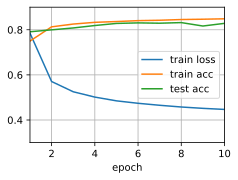

In [18]:
num_epochs, lr = 10, 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

Now that training is complete,
our model is ready to classify some images.
Given a series of images,
we will compare their actual labels
(first line of text output)
and the model predictions
(second line of text output).

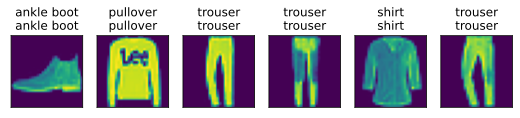

In [19]:
def predict_ch3(net, test_iter, n=6):  #@save
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true+'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape(n, 28, 28), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## Summary

With softmax regression, we can train models for multi-category classification.
The training loop is very similar to that in linear regression:
retrieve and read data, define models and loss functions,
then train models using optimization algorithms.
As you will soon find out, most common deep learning models
have similar training procedures.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause (hint: try to calculate the size of $\exp(50)$)?
1. The function `cross_entropy` in this section is implemented according to the definition of the cross-entropy loss function.  What could be the problem with this implementation (hint: consider the domain of the logarithm)?
1. What solutions you can think of to fix the two problems above?
1. Is it always a good idea to return the most likely label. E.g., would you do this for medical diagnosis?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?



[Discussions](https://discuss.d2l.ai/t/51)